# Correlation Study Notebook

## Objectives

* Answer business requirement 1: 
  * The client is interested in discovering how the house attributes correlate with the sale price.

## Inputs

* outputs/datasets/cleaned/HousePricesCleaned.csv

## Outputs

* Generate code that answers business requirement 1 and can be used to build Streamlit App
* Save plots in folder for documentation

## Conclusions

* The size of a property matters. Higher values of 1stFlrSF, GarageArea, GrLivArea, MasVnrArea, OpenPorchSF and TotalBsmtSF are associated with higher sale price.
* Time matters. Recently built houses, and houses with recently built garages and recently added remodel have higher sale prices.  
* Quality matters. Houses with higher overall quality and kitchen quality ratings have higher sale prices. 


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-issues'

# Load Data

In [4]:
import pandas as pd
df = pd.read_csv("outputs/datasets/cleaned/HousePricesCleaned.csv")
df.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GrLivArea,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.000000,No,706,GLQ,150,548,RFn,1710,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.000000,Gd,978,ALQ,284,460,RFn,1262,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.000000,Mn,486,GLQ,434,608,RFn,1786,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,0.0,2.869214,No,216,ALQ,540,642,Unf,1717,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,0.0,4.000000,Av,655,GLQ,490,836,RFn,2198,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000


# Data Exploration

We start with data profiling report so that we get more familiar with the content of the dataset. We check variable type and distribution, missing levels and how each variable may related to our target.

* We import pandas_profiling library and generate a profile report of our data

In [ ]:
from pandas_profiling import ProfileReport
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

The above report reveals that

* Nine features have missing values.
* EnclosedPorch and WoodDeckSF have 90.7% and 89.4% missing values respectively.

---

## Correlation and PPS Analyses

Our dataset has four categorical variables that are of object data type. So we need to encode them so that we can use them to calculate correlation coefficients.

In [6]:
from feature_engine.encoding import OneHotEncoder
encoder = OneHotEncoder(variables=df.columns[df.dtypes=='object'].to_list(), drop_last=False)
df_ohe = encoder.fit_transform(df)
print(df_ohe.shape)
df_ohe.head(5)

(1460, 37)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtFinSF1,BsmtUnfSF,GarageArea,GrLivArea,LotArea,LotFrontage,MasVnrArea,...,BsmtFinType1_BLQ,BsmtFinType1_LwQ,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_None,GarageFinish_Fin,KitchenQual_Gd,KitchenQual_TA,KitchenQual_Ex,KitchenQual_Fa
0,856,854.0,3.000000,706,150,548,1710,8450,65.0,196.0,...,0,0,1,0,0,0,1,0,0,0
1,1262,0.0,3.000000,978,284,460,1262,9600,80.0,0.0,...,0,0,1,0,0,0,0,1,0,0
2,920,866.0,3.000000,486,434,608,1786,11250,68.0,162.0,...,0,0,1,0,0,0,1,0,0,0
3,961,0.0,2.869214,216,540,642,1717,9550,60.0,0.0,...,0,0,0,1,0,0,1,0,0,0
4,1145,0.0,4.000000,655,490,836,2198,14260,84.0,350.0,...,0,0,1,0,0,0,1,0,0,0


* Now our dataset has 37 columns, because the categorical variables have been encoded and their categories converted to separate columns with binary values (0 0r 1).

* Next, we define functions that will calculate the correlations, create heatmaps and display them.
* We save each heatmap to docs directory for later use in the documentation of this project.

In [20]:
import numpy as np
import ppscore as pps
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

def heatmap_corr(df,threshold, figsize=(20,12), font_annot = 8):
  """
  Function to create heatmap using correlations.
  """
  if len(df.columns) > 1:
    mask = np.zeros_like(df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask[abs(df) < threshold] = True

    fig, axes = plt.subplots(figsize=figsize)
    sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                linewidth=0.5
                     )
    axes.set_yticklabels(df.columns, rotation = 0)
    plt.ylim(len(df.columns),0)
     # Save heatmaps to docs folder
    if df.name == "corr_spearman":
      plt.savefig(f'docs/plots/heatmap_corr_spearman.png', bbox_inches='tight')
    else:
      plt.savefig(f'docs/plots/heatmap_corr_pearson.png', bbox_inches='tight')
    plt.show()


def heatmap_pps(df,threshold, figsize=(20,12), font_annot = 8):
    """
    Function to create heatmap using pps.
    """
    if len(df.columns) > 1:

      mask = np.zeros_like(df, dtype=np.bool)
      mask[abs(df) < threshold] = True

      fig, ax = plt.subplots(figsize=figsize)
      ax = sns.heatmap(df, annot=True, xticklabels=True,yticklabels=True,
                       mask=mask,cmap='rocket_r', annot_kws={"size": font_annot},
                       linewidth=0.05,linecolor='grey')
      
      plt.ylim(len(df.columns),0)
      # Save heatmap to docs folder
      plt.savefig(f'docs/plots/heatmap_pps.png', bbox_inches='tight')
      plt.show()


def CalculateCorrAndPPS(df):
  """
  Function to calculate correlations and pps.
  """
  df_corr_spearman = df.corr(method="spearman")
  df_corr_spearman.name = 'corr_spearman'
  df_corr_pearson = df.corr(method="pearson")
  df_corr_pearson.name = 'corr_pearson'

  pps_matrix_raw = pps.matrix(df)
  pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

  pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
  print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
  print(pps_score_stats.round(3))

  return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix,CorrThreshold,PPS_Threshold,
                      figsize=(20,12), font_annot=8 ):
  """
  Function to display the correlations and pps.
  """

  print("\n")
  print("* Analyze how the target variable for your ML models are correlated with other variables (features and target)")
  print("* Analyze multi-colinearity, that is, how the features are correlated among themselves")

  print("\n")
  print("*** Heatmap: Spearman Correlation ***")
  print("It evaluates monotonic relationship \n")
  heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Pearson Correlation ***")
  print("It evaluates the linear relationship between two continuous variables \n")
  heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Power Predictive Score (PPS) ***")
  print(f"PPS detects linear or non-linear relationships between two columns.\n"
        f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
  heatmap_pps(df=pps_matrix,threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

* In the following cell, we call the function that calculates the correlations and pps.
* This function invokes the .corr() method where we pass spearman and pearson to evaluate the linear and monotonic relationships respectively between the features and the target.

In [8]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  420.0  0.053  0.094  0.0  0.0  0.0  0.067  0.579


* Then we display the correlations and pps by calling the DisplayCorrAndPPS function we defined above.



* Analyze how the target variable for your ML models are correlated with other variables (features and target)
* Analyze multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



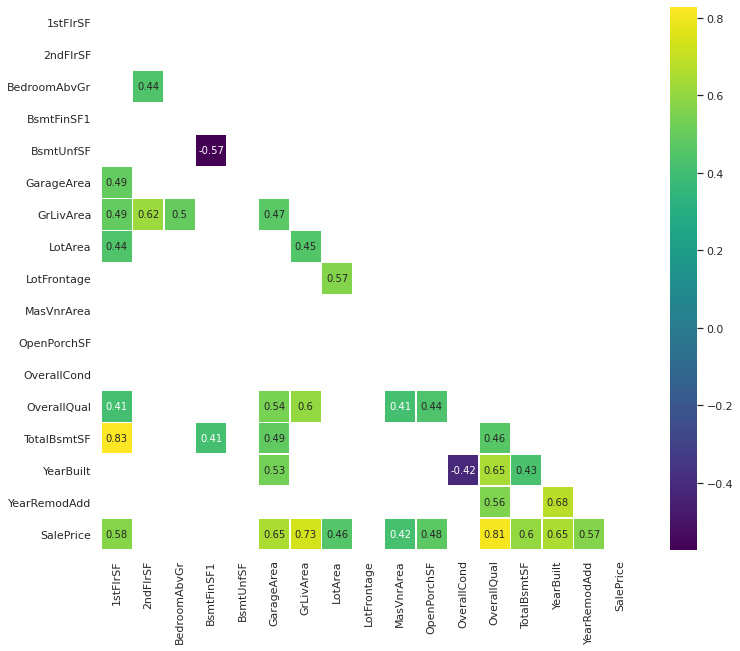



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



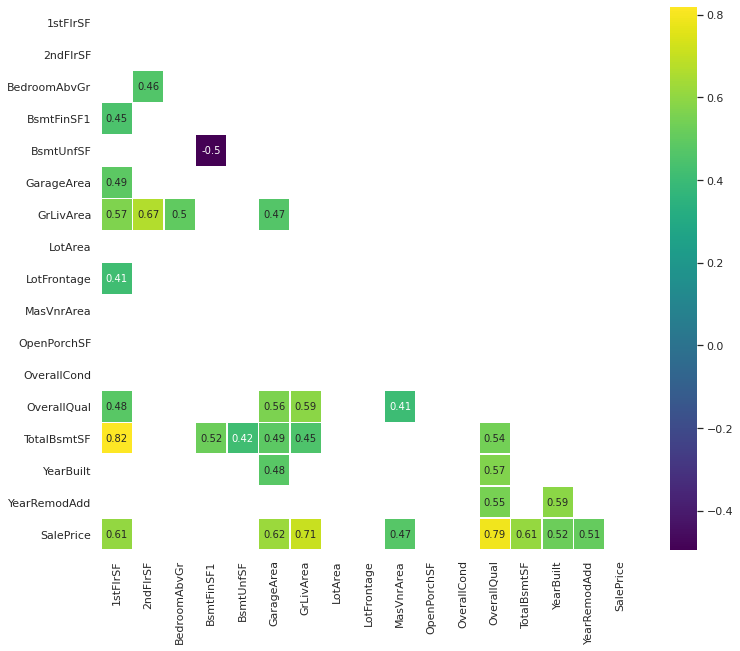



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



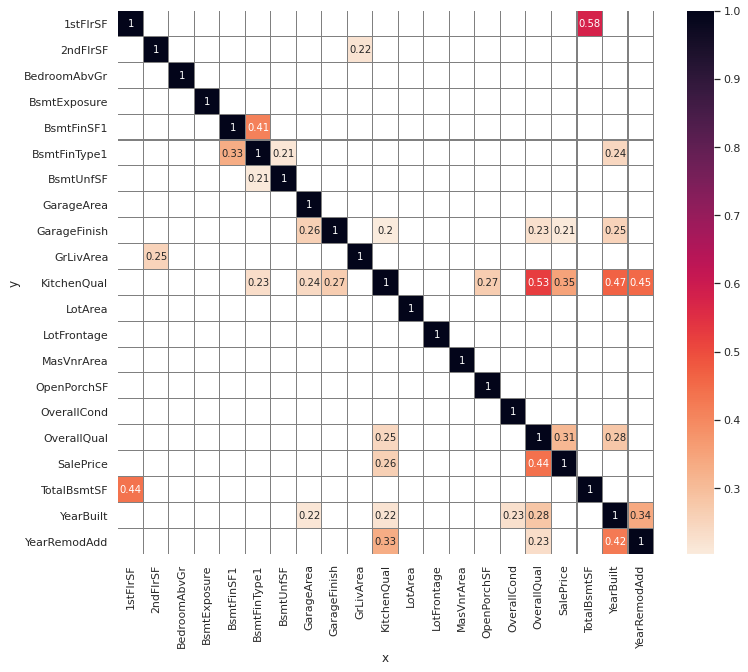

In [21]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

* When we calculate the correlations with the .corr() method, the return value is a pandas series, and the first item is the correlation between SalePrice and SalePrice. 
* As this correlation is 1 and carries no information, we use [1:] to exclude it from the series.
* Now we sort the remaining values considering the aboslute value, which is done by setting key=abs

* We know from the heatmaps above that the number of features that have correlations above the threshold of 0.4 is less than 10. So we show the first 10 values of each series below.

In [10]:
corr_spearman = df_ohe.corr(method='spearman')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head(10)
corr_spearman

OverallQual       0.809829
GrLivArea         0.731310
YearBuilt         0.652682
GarageArea        0.649379
TotalBsmtSF       0.602725
KitchenQual_TA   -0.581803
1stFlrSF          0.575408
YearRemodAdd      0.571159
KitchenQual_Gd    0.478583
OpenPorchSF       0.477561
Name: SalePrice, dtype: float64

In [11]:
corr_pearson = df_ohe.corr(method='pearson')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head(10)
corr_pearson

OverallQual       0.790982
GrLivArea         0.708624
GarageArea        0.623431
TotalBsmtSF       0.613581
1stFlrSF          0.605852
YearBuilt         0.522897
KitchenQual_TA   -0.519298
YearRemodAdd      0.507101
KitchenQual_Ex    0.504094
MasVnrArea        0.472614
Name: SalePrice, dtype: float64

* Let's merge the pearson and spearman correlations. We use set to avoid duplication of features.

In [12]:
top_n = 10
set(corr_pearson[:top_n].index.to_list() + corr_spearman[:top_n].index.to_list())

{'1stFlrSF',
 'GarageArea',
 'GrLivArea',
 'KitchenQual_Ex',
 'KitchenQual_Gd',
 'KitchenQual_TA',
 'MasVnrArea',
 'OpenPorchSF',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd'}

Based on the correlation study results, we will focus on the following variables and their relationship to house sale prices.
* 1stFlrSF
* GarageArea
* GrLivArea
* KitchenQual
* MasVnrArea
* OpenPorchSF
* OverallQual
* TotalBsmtSF
* YearBuilt
* YearRemodAdd

* These features reflect the relevance and potential predictive power of the size of a property, the quality of a house and whether the property has been built or remodeled recently or not.

In [13]:
vars_to_study = ['1stFlrSF', 'GarageArea', 'GrLivArea', 'KitchenQual', 'MasVnrArea', 'OpenPorchSF', 'OverallQual', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd']
vars_to_study

['1stFlrSF',
 'GarageArea',
 'GrLivArea',
 'KitchenQual',
 'MasVnrArea',
 'OpenPorchSF',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd']

# EDA on selected variables

* Now we do exploratory data analysis using the features that have moderate or high correlation with out target, SalePrice.

* We create a separate DataFrame for the EDA by adding SalePrice so that we can use data visualization to draw insights about the relationship between each feature and the target.

In [14]:
df_eda = df.filter(vars_to_study + ['SalePrice'])
df_eda.head()

,1stFlrSF,GarageArea,GrLivArea,KitchenQual,MasVnrArea,OpenPorchSF,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,548,1710,Gd,196.0,61,7,856,2003,2003,208500
1,1262,460,1262,TA,0.0,0,6,1262,1976,1976,181500
2,920,608,1786,Gd,162.0,42,7,920,2001,2002,223500
3,961,642,1717,Gd,0.0,35,7,756,1915,1970,140000
4,1145,836,2198,Gd,350.0,84,8,1145,2000,2000,250000


## Target Analysis

### Distribution of Sales Price

* First, we plot the target variable, SalePrice, in a histogram to have an idea of its distribution.

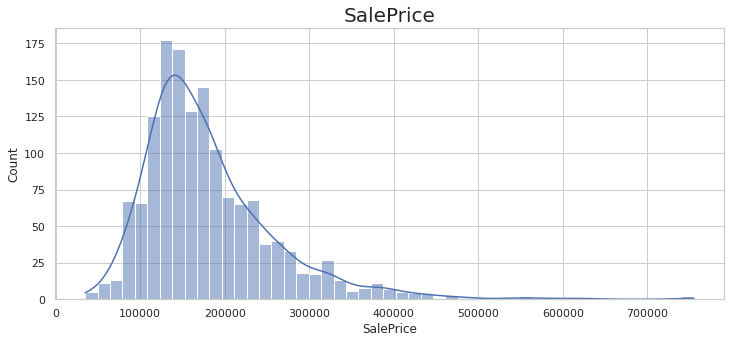

In [15]:
sns.set_style('whitegrid')
target_var = 'SalePrice'
time = ['YearBuilt', 'YearRemodAdd']

def plot_target_hist(df, target_var):
  """
  Function to plot a histogram of the target and
  save the figure to folder.
  """
  plt.figure(figsize=(12, 5))
  sns.histplot(data=df, x=target_var, kde=True)
  plt.title(f"{target_var}", fontsize=20)
  plt.savefig(f'docs/plots/hist_plot_{target_var}.png', bbox_inches='tight')        
  plt.show()

plot_target_hist(df, target_var)

* As we note from the histogram above, the target variable is silightly skewed to the right. Some houses have very high sale prices, much higher that the typical property.

### Bivariate plots

* In this exercise, We are interested in answering business requirement 1, which is 'discovering how the house attributes correlate with the sale price.'

* So we plot sale price in relation to both numerical and categorical features. 

<Figure size 864x360 with 0 Axes>

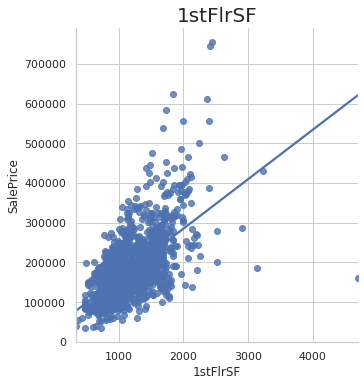

<Figure size 864x360 with 0 Axes>

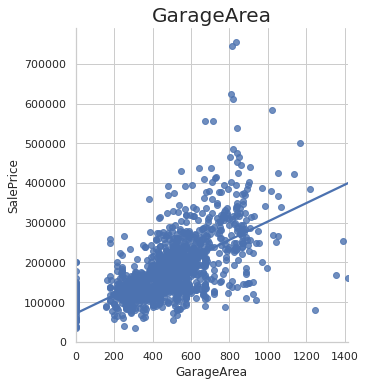

<Figure size 864x360 with 0 Axes>

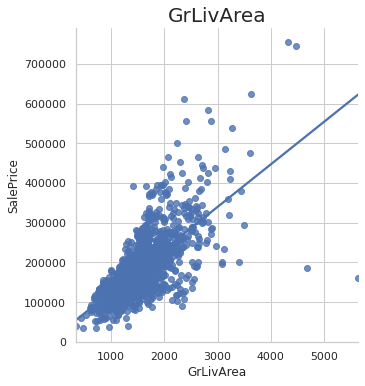

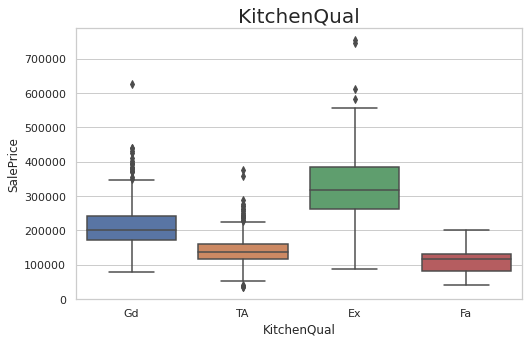

<Figure size 864x360 with 0 Axes>

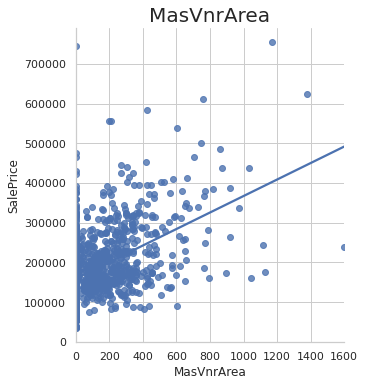

<Figure size 864x360 with 0 Axes>

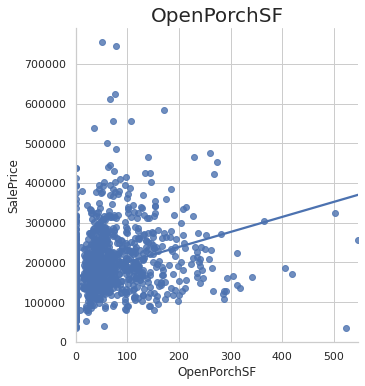

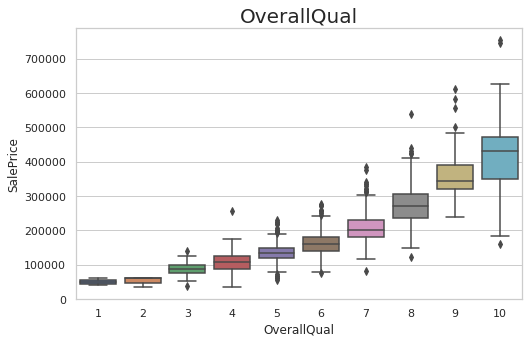

<Figure size 864x360 with 0 Axes>

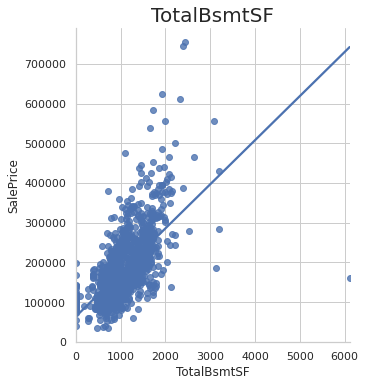

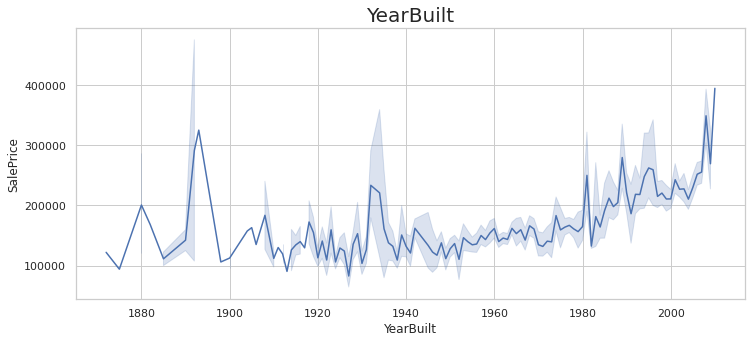

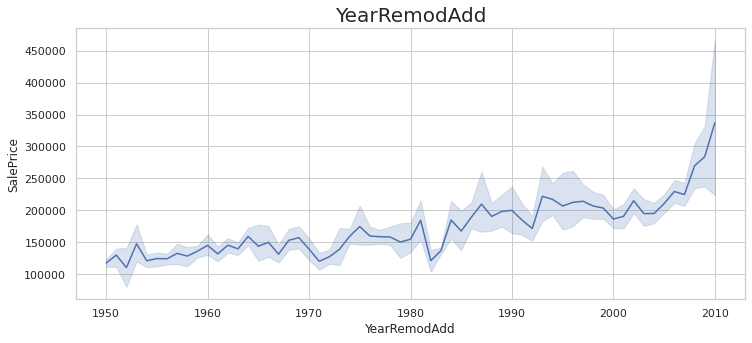

In [22]:
def plot_lm(df, col, target_var):
  """
  Function to create linear regression plots of the target and
  features with continuous values.
  It saves each figure to folder.
  """
  plt.figure(figsize=(12, 5))
  sns.lmplot(data=df, x=col, y=target_var, ci=None)
  plt.title(f"{col}", fontsize=20)
  plt.savefig(f'docs/plots/lm_plot_price_by_{col}.png', bbox_inches='tight')        
  plt.show()

def plot_line(df, col, target_var):
  """
  Function to create a line plot of the target and
  time variables (years).
  It saves each figure to folder.
  """
  plt.figure(figsize=(12, 5))
  sns.lineplot(data=df, x=col, y=target_var)
  plt.title(f"{col}", fontsize=20)
  plt.savefig(f'docs/plots/line_plot_price_by_{col}.png', bbox_inches='tight')        
  plt.show()

def plot_box(df, col, target_var):
  """
  Function to create a box plot of the target and
  categorical variables.
  It saves each figure to folder.
  """
  plt.figure(figsize=(8, 5))
  sns.boxplot(data=df, x=col, y=target_var) 
  plt.title(f"{col}", fontsize=20)
  plt.savefig(f'docs/plots/box_plot_price_by_{col}', bbox_inches='tight')
  plt.show()


for col in vars_to_study:
  if len(df_eda[col].unique()) <= 10:
    plot_box(df_eda, col, target_var)
    print("\n\n")
  else:
    if col in time:
      plot_line(df_eda, col, target_var)
      print("\n\n")
    else:
      plot_lm(df_eda, col, target_var)
      print("\n\n")

From the plots, we note that higher values of the features tend to be associated with higher property value. This is true for the linear regression plots, box plots as well as line plots (time variables). 

* Similar to the observation we made about the distribution of the target having extreme values, there seem to be outliers in the features as well.

* We will handle outliers in the feature engineering notebook to make the data good for modeling.

---

# Conclusions and Next steps

We make the following observations from both the correlation analyses and the plots.

* The size of a property matters. Higher values of 1stFlrSF, GarageArea, GrLivArea, MasVnrArea, OpenPorchSF and TotalBsmtSF are associated with higher sale price.
* Time matters. Recently built houses, and houses with recently built garages and recently added remodel have higher sale prices.  
* Quality matters. Houses with higher overall quality and kitchen quality ratings have higher sale prices. 